In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "7" 

import numpy as np
import random
import pandas as pd
import pickle
import sys
import timeit
from tqdm import tqdm
import glob

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc,confusion_matrix
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [2]:
class SoftGateCascade(nn.Module):
    
    def __init__(self, n_models):
        super(SoftGateCascade, self).__init__()
        self.n_models = n_models
        
        self.conf2weight = nn.Linear(n_models, n_models)

    def forward(self, confs):
        '''
        confs: batch_size x n_models
        probs: batch_size x n_models
        '''
        out = self.conf2weight(confs)
        out = relu(out)
        out[:,0] += 0.01
        out = out/torch.sum(out,1).unsqueeze(-1).expand(out.shape)
        return out

In [3]:
def load_data(data_dir, model_zoo, model_costs, confidence='probability', batch_size=256, tc=False):
    model = model_zoo[0]
    if tc:
        model = 'tc_' + model
    data_df = pd.read_csv(f'{data_dir}{model}.csv')
    data_df = data_df[['id','t_since_intime','y_pred','y_true']]
    data_df = data_df.rename(columns={'y_pred': f'y_pred_{model}'})
    data_df = data_df.set_index(['id','t_since_intime','y_true'])

    for model in model_zoo[1:]:
        if tc:
            model = 'tc_' + model
        model_df = pd.read_csv(f'{data_dir}{model}.csv')
        model_df = model_df[['id','t_since_intime','y_pred','y_true']]
        model_df = model_df.rename(columns={'y_pred': f'y_pred_{model}'})
        model_df = model_df.set_index(['id','t_since_intime','y_true'])
        data_df = data_df.join(model_df, how='inner')

    data_df = data_df.reset_index(drop=False)
    
    N = len(data_df)
    confs = []
    probs =[]
    costs = []

    for model,c in zip(model_zoo,model_costs):
        if tc:
            model = 'tc_' + model
        ps = np.array(data_df[f'y_pred_{model}']).reshape(-1,1)
        probs.append(ps)
        if confidence == 'probability':
            cs = [max(p, 1-p) for p in ps]
        else:
            cs = [1 + p*np.log(p) + (1-p)*np.log(1-p) for p in ps]
            
        confs.append(np.array(cs).reshape(-1,1))
        costs.append(np.ones([N,1]) * c)
        
    confs = torch.from_numpy(np.concatenate(confs, axis=1)).float()
    probs = torch.from_numpy(np.concatenate(probs, axis=1)).float()
    costs = torch.from_numpy(np.concatenate(costs, axis=1)).float()
    labels = torch.from_numpy(np.array(data_df['y_true'])).long()
    
    dataset = TensorDataset(confs, probs, labels, costs)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return data_loader


In [12]:
softmax = nn.Softmax(dim=-1)
relu = nn.ReLU()
tanh = nn.Tanh()

def eval_model(model, data_loader, CUDA = True):
    model.eval()
    y_true = []
    y_score = []
    
    y_cost = []
    ll = 0
    for i, batch in enumerate(data_loader):
        confs, probs, labels, costs = batch[0], batch[1], batch[2], batch[3]
        if CUDA:
            confs, probs, labels, costs = confs.cuda(), probs.cuda(), labels.cuda(), costs.cuda()
        weights = model(confs)
        bs = weights.shape[0]

        weights[:,0] += 0.01
        choices = torch.argmax(weights, 1)
#         weights_norm = torch.sum(weights,1)
#         choices[weights_norm == 0] = 0
        
#         preds0 = torch.sum(weights*(1-probs), 1).unsqueeze(-1)
#         preds1 = torch.sum(weights*(probs), 1).unsqueeze(-1)
#         preds = torch.cat([preds0, preds1],1)

        preds1 = probs[np.arange(bs), choices].unsqueeze(-1)
        preds = torch.cat([1-preds1, preds1],1)
        loss = criterion(torch.log(preds), labels)
        
        y_score.extend(preds[:,1].cpu().tolist())
        y_cost.extend(costs[np.arange(bs), choices].cpu().tolist())
        y_true.extend(labels.cpu().tolist())
        
        ll += loss.item()
        
    auc = roc_auc_score(y_true, y_score)   
    return auc, ll/i, np.mean(y_cost)

def train_model(model, validation_loader, test_loader, C, save_model_file=None, lr=1e-1, lambda1 = 1e-2, lambda2 = 1e-1, epochs=100, CUDA=True):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=10,factor=0.5, verbose=True)

    # criterion=nn.CrossEntropyLoss()
    if CUDA:
        model = model.cuda()

    train_losses = []
    test_losses = []
    test_aucs = []
    test_costs = []
    
    best_auc = 0
    for epoch in tqdm(range(epochs)):
    #     print('Epoch', epoch)
        ll = 0
        for i, batch in enumerate(validation_loader):
            # bs x n_models
            confs, probs, labels, costs = batch[0], batch[1], batch[2], batch[3]
            if CUDA:
                confs, probs, labels, costs = confs.cuda(), probs.cuda(), labels.cuda(), costs.cuda()
            bs = confs.shape[0]

            model.train()
            optimizer.zero_grad()

            # bs x n_models
            weights = model(confs)
    #         preds0 = torch.sum(weights*(1-probs), 1).unsqueeze(-1)
    #         preds1 = torch.sum(weights*(probs), 1).unsqueeze(-1)

            preds1 = torch.sum(weights*probs,1).unsqueeze(-1)
            preds = torch.cat([1-preds1, preds1],1)

            loss = criterion(torch.log(preds), labels)
            loss += lambda1 * torch.norm(weights, 1) / bs
            loss += lambda2 * (torch.sum(weights*costs) / bs - C)

            loss.backward()
            optimizer.step()

            ll += loss.item()

        train_loss = ll/i
        train_losses.append(train_loss)
        test_auc, test_loss, test_cost = eval_model(model, test_loader)
        if test_auc > best_auc:
            best_auc = test_auc
            if save_model_file:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss
                    }, f'{save_model_file}.auc{test_auc:.4f}.cost{test_cost:.1f}.ptmodel')
                
        scheduler.step(train_loss)
    
        test_losses.append(test_loss)
        test_aucs.append(test_auc)
        test_costs.append(test_cost)

    plt.plot(np.arange(epochs), train_losses, label = 'Train loss')  
    plt.plot(np.arange(epochs), test_losses, label = 'Test loss')
    plt.legend()
    plt.show()

    plt.plot(np.arange(epochs), test_costs, label = 'Test cost')
    plt.legend()
    plt.show()

    plt.plot(np.arange(epochs), test_aucs, label = 'Test auc')
    plt.legend()
    plt.show()
    
    return model, train_losses, test_losses, test_costs, test_aucs

Entropy no tc


 81%|████████  | 81/100 [06:37<01:33,  4.90s/it]

Epoch    81: reducing learning rate of group 0 to 5.0000e-02.


100%|██████████| 100/100 [08:10<00:00,  4.91s/it]


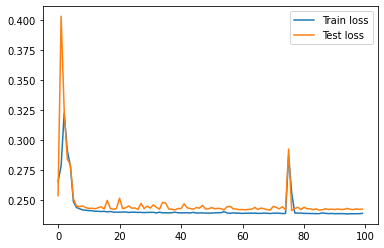

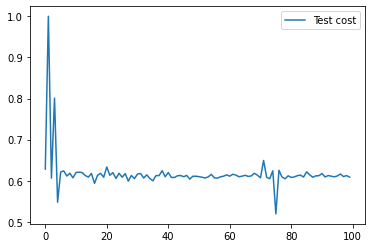

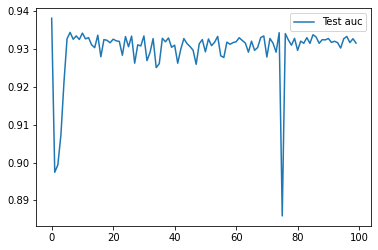

Entropy tc


 14%|█▍        | 14/100 [01:08<07:00,  4.89s/it]

Epoch    14: reducing learning rate of group 0 to 5.0000e-02.


 55%|█████▌    | 55/100 [04:16<03:03,  4.09s/it]

Epoch    55: reducing learning rate of group 0 to 2.5000e-02.


 66%|██████▌   | 66/100 [05:10<02:45,  4.88s/it]

Epoch    66: reducing learning rate of group 0 to 1.2500e-02.


 77%|███████▋  | 77/100 [06:04<01:52,  4.91s/it]

Epoch    77: reducing learning rate of group 0 to 6.2500e-03.


 88%|████████▊ | 88/100 [06:58<00:58,  4.89s/it]

Epoch    88: reducing learning rate of group 0 to 3.1250e-03.


 99%|█████████▉| 99/100 [07:52<00:04,  4.90s/it]

Epoch    99: reducing learning rate of group 0 to 1.5625e-03.


100%|██████████| 100/100 [07:57<00:00,  4.77s/it]


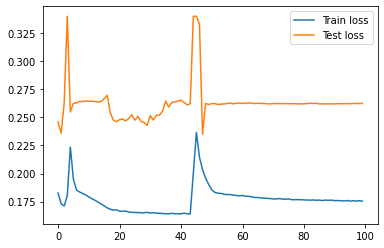

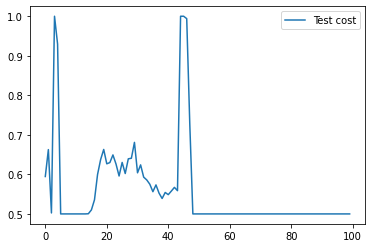

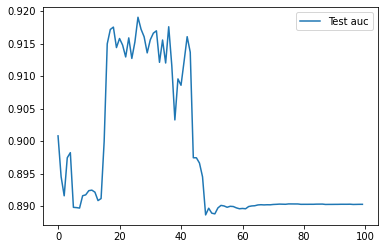

Prob. no tc


 20%|██        | 20/100 [01:38<06:32,  4.90s/it]

Epoch    20: reducing learning rate of group 0 to 5.0000e-02.


 32%|███▏      | 32/100 [02:36<05:33,  4.90s/it]

Epoch    32: reducing learning rate of group 0 to 2.5000e-02.


 43%|████▎     | 43/100 [03:30<04:38,  4.89s/it]

Epoch    43: reducing learning rate of group 0 to 1.2500e-02.


 54%|█████▍    | 54/100 [04:24<03:45,  4.90s/it]

Epoch    54: reducing learning rate of group 0 to 6.2500e-03.


 65%|██████▌   | 65/100 [05:18<02:51,  4.91s/it]

Epoch    65: reducing learning rate of group 0 to 3.1250e-03.


 76%|███████▌  | 76/100 [06:09<01:41,  4.23s/it]

Epoch    76: reducing learning rate of group 0 to 1.5625e-03.


 87%|████████▋ | 87/100 [06:52<00:50,  3.91s/it]

Epoch    87: reducing learning rate of group 0 to 7.8125e-04.


 98%|█████████▊| 98/100 [07:35<00:07,  3.90s/it]

Epoch    98: reducing learning rate of group 0 to 3.9063e-04.


100%|██████████| 100/100 [07:42<00:00,  4.63s/it]


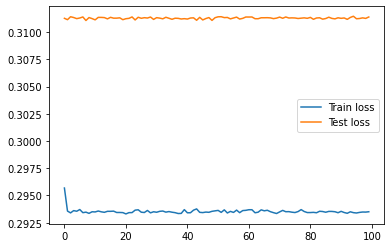

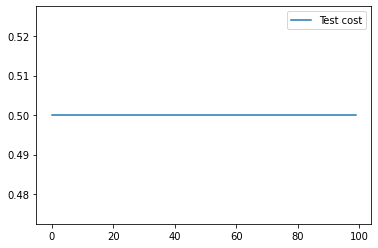

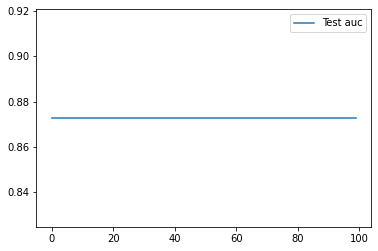

Prob. tc


 71%|███████   | 71/100 [05:30<02:22,  4.91s/it]

Epoch    71: reducing learning rate of group 0 to 5.0000e-02.


100%|██████████| 100/100 [07:52<00:00,  4.73s/it]


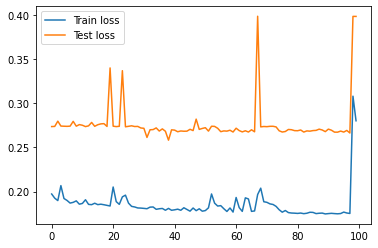

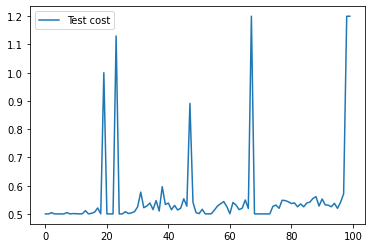

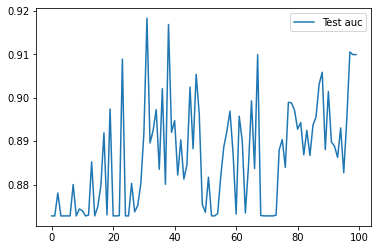

In [5]:
CUDA = True
C = 0.8
model_zoo = ['rnn_vitals_1hr','rnn_vitals_2hr','rnn_vitals_6hr','rnn_vitals_12hr',
             'rnn_vitals_labs_1hr','rnn_vitals_labs_2hr','rnn_vitals_labs_6hr','rnn_vitals_labs_12hr',
             'rnn_vitals_labs_csu_12hr']
model_costs = [0.5,0.6,0.8,1,0.5,0.6,0.8,1.1,1.2]

class_weights = torch.Tensor([1,5]).float()
if CUDA:
    class_weights = class_weights.cuda()
criterion = nn.NLLLoss(weight=class_weights)

epochs = 100
lr = 1e-1

new_results = {}

validation_results_dir = '../rnn/prediction_on_validation_results/'
test_results_dir = '../rnn/prediction_on_test_results/'

out_dir = 'saved_models/'
file_name = f'{len(model_zoo)}_models_C{C}_cw{class_weights[-1].item()}'

print('Entropy no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Entropy_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Entropy_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Entropy tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}EntropyTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Entropy_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Prob_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Prob_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}ProbTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Prob_TC']= (train_losses, test_losses, test_costs, test_aucs)

Entropy no tc


 26%|██▌       | 26/100 [02:09<06:06,  4.96s/it]

Epoch    26: reducing learning rate of group 0 to 5.0000e-02.


 40%|████      | 40/100 [03:17<04:53,  4.90s/it]

Epoch    40: reducing learning rate of group 0 to 2.5000e-02.


 68%|██████▊   | 68/100 [05:36<02:37,  4.91s/it]

Epoch    68: reducing learning rate of group 0 to 1.2500e-02.


 79%|███████▉  | 79/100 [06:27<01:29,  4.25s/it]

Epoch    79: reducing learning rate of group 0 to 6.2500e-03.


100%|██████████| 100/100 [07:56<00:00,  4.77s/it]


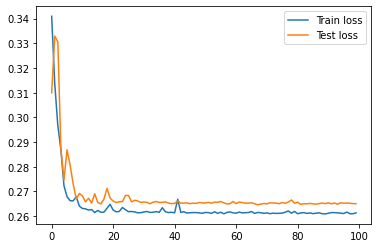

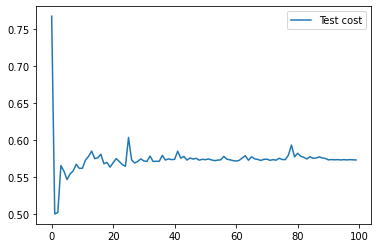

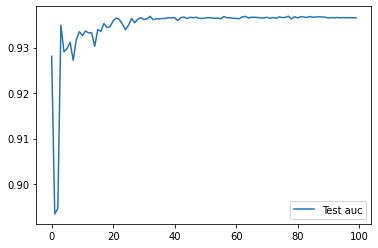

Entropy tc


 73%|███████▎  | 73/100 [05:58<02:12,  4.91s/it]

Epoch    73: reducing learning rate of group 0 to 5.0000e-02.


 84%|████████▍ | 84/100 [06:52<01:18,  4.90s/it]

Epoch    84: reducing learning rate of group 0 to 2.5000e-02.


 95%|█████████▌| 95/100 [07:46<00:24,  4.88s/it]

Epoch    95: reducing learning rate of group 0 to 1.2500e-02.


100%|██████████| 100/100 [08:11<00:00,  4.91s/it]


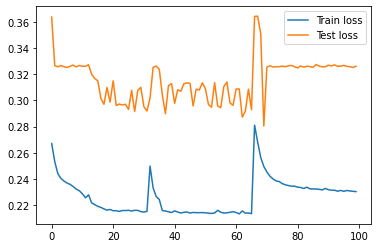

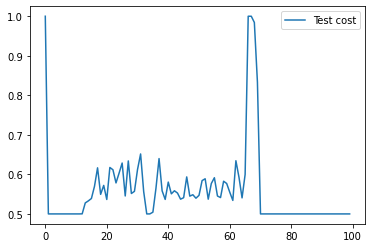

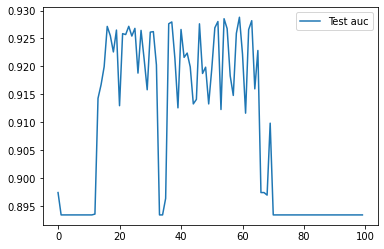

Prob. no tc


 17%|█▋        | 17/100 [01:24<06:47,  4.91s/it]

Epoch    17: reducing learning rate of group 0 to 5.0000e-02.


 28%|██▊       | 28/100 [02:18<05:54,  4.92s/it]

Epoch    28: reducing learning rate of group 0 to 2.5000e-02.


 39%|███▉      | 39/100 [03:12<04:59,  4.91s/it]

Epoch    39: reducing learning rate of group 0 to 1.2500e-02.


 50%|█████     | 50/100 [04:06<04:06,  4.94s/it]

Epoch    50: reducing learning rate of group 0 to 6.2500e-03.


100%|██████████| 100/100 [08:14<00:00,  4.94s/it]


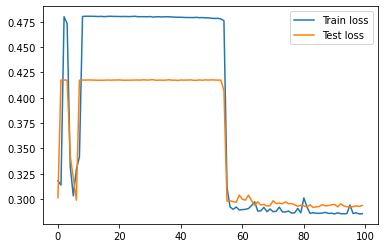

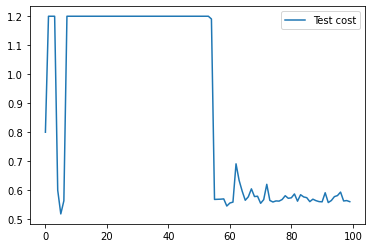

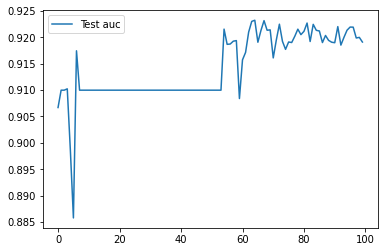

Prob. tc


 52%|█████▏    | 52/100 [04:11<03:13,  4.04s/it]

Epoch    52: reducing learning rate of group 0 to 5.0000e-02.


 63%|██████▎   | 63/100 [04:54<02:23,  3.89s/it]

Epoch    63: reducing learning rate of group 0 to 2.5000e-02.


 74%|███████▍  | 74/100 [05:46<02:07,  4.90s/it]

Epoch    74: reducing learning rate of group 0 to 1.2500e-02.


 85%|████████▌ | 85/100 [06:40<01:13,  4.92s/it]

Epoch    85: reducing learning rate of group 0 to 6.2500e-03.


 96%|█████████▌| 96/100 [07:34<00:19,  4.91s/it]

Epoch    96: reducing learning rate of group 0 to 3.1250e-03.


100%|██████████| 100/100 [07:53<00:00,  4.74s/it]


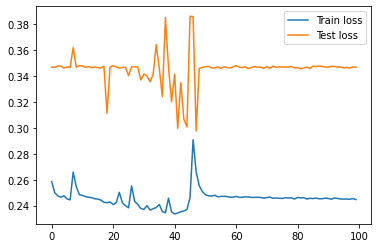

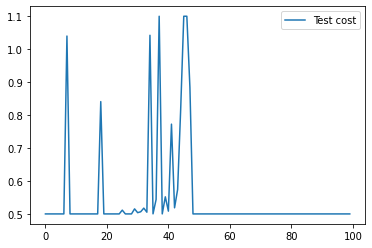

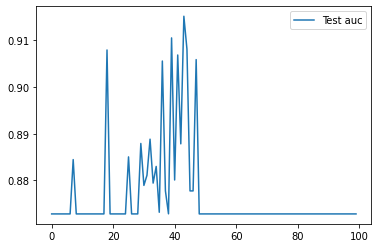

In [6]:
CUDA = True
C = 0.8
model_zoo = ['rnn_vitals_1hr','rnn_vitals_2hr','rnn_vitals_6hr','rnn_vitals_12hr',
             'rnn_vitals_labs_1hr','rnn_vitals_labs_2hr','rnn_vitals_labs_6hr','rnn_vitals_labs_12hr',
             'rnn_vitals_labs_csu_12hr']
model_costs = [0.5,0.6,0.8,1,0.5,0.6,0.8,1.1,1.2]

class_weights = torch.Tensor([1,10]).float()
if CUDA:
    class_weights = class_weights.cuda()
criterion = nn.NLLLoss(weight=class_weights)

epochs = 100
lr = 1e-1

new_results = {}

validation_results_dir = '../rnn/prediction_on_validation_results/'
test_results_dir = '../rnn/prediction_on_test_results/'

out_dir = 'saved_models/'
file_name = f'{len(model_zoo)}_models_C{C}_cw{class_weights[-1].item()}'

print('Entropy no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Entropy_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Entropy_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Entropy tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}EntropyTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Entropy_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Prob_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Prob_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}ProbTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Prob_TC']= (train_losses, test_losses, test_costs, test_aucs)

Entropy no tc


 12%|█▏        | 12/100 [00:58<07:11,  4.91s/it]

Epoch    12: reducing learning rate of group 0 to 5.0000e-02.


 23%|██▎       | 23/100 [01:53<06:20,  4.94s/it]

Epoch    23: reducing learning rate of group 0 to 2.5000e-02.


 34%|███▍      | 34/100 [02:47<05:26,  4.95s/it]

Epoch    34: reducing learning rate of group 0 to 1.2500e-02.


 45%|████▌     | 45/100 [03:42<04:31,  4.95s/it]

Epoch    45: reducing learning rate of group 0 to 6.2500e-03.


 56%|█████▌    | 56/100 [04:36<03:37,  4.95s/it]

Epoch    56: reducing learning rate of group 0 to 3.1250e-03.


 67%|██████▋   | 67/100 [05:30<02:42,  4.93s/it]

Epoch    67: reducing learning rate of group 0 to 1.5625e-03.


 78%|███████▊  | 78/100 [06:25<01:48,  4.94s/it]

Epoch    78: reducing learning rate of group 0 to 7.8125e-04.


 89%|████████▉ | 89/100 [07:19<00:55,  5.00s/it]

Epoch    89: reducing learning rate of group 0 to 3.9063e-04.


100%|██████████| 100/100 [08:14<00:00,  4.94s/it]

Epoch   100: reducing learning rate of group 0 to 1.9531e-04.


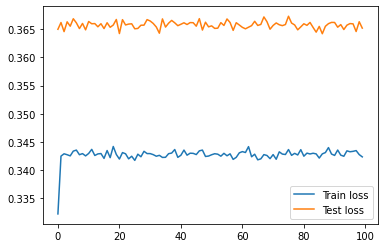

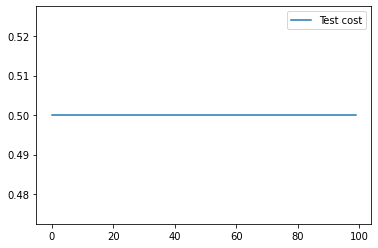

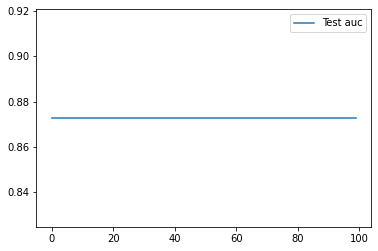

Entropy tc


 15%|█▌        | 15/100 [01:14<06:58,  4.92s/it]

Epoch    15: reducing learning rate of group 0 to 5.0000e-02.


 26%|██▌       | 26/100 [02:08<06:02,  4.90s/it]

Epoch    26: reducing learning rate of group 0 to 2.5000e-02.


 37%|███▋      | 37/100 [03:02<05:08,  4.89s/it]

Epoch    37: reducing learning rate of group 0 to 1.2500e-02.


 48%|████▊     | 48/100 [03:56<04:14,  4.89s/it]

Epoch    48: reducing learning rate of group 0 to 6.2500e-03.


 59%|█████▉    | 59/100 [04:44<02:46,  4.07s/it]

Epoch    59: reducing learning rate of group 0 to 3.1250e-03.


 70%|███████   | 70/100 [05:30<02:18,  4.63s/it]

Epoch    70: reducing learning rate of group 0 to 1.5625e-03.


 81%|████████  | 81/100 [06:24<01:33,  4.91s/it]

Epoch    81: reducing learning rate of group 0 to 7.8125e-04.


 92%|█████████▏| 92/100 [07:19<00:39,  4.93s/it]

Epoch    92: reducing learning rate of group 0 to 3.9063e-04.


100%|██████████| 100/100 [07:58<00:00,  4.78s/it]


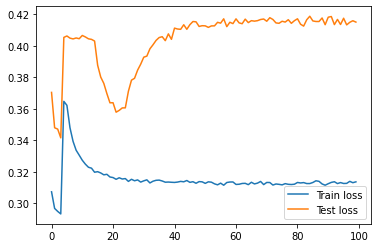

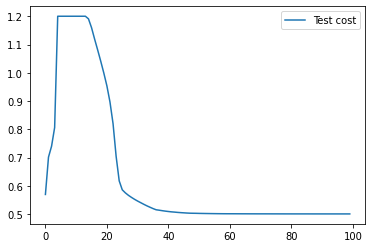

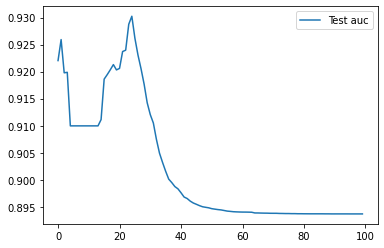

Prob. no tc


 14%|█▍        | 14/100 [01:08<07:02,  4.91s/it]

Epoch    14: reducing learning rate of group 0 to 5.0000e-02.


 25%|██▌       | 25/100 [02:02<06:08,  4.91s/it]

Epoch    25: reducing learning rate of group 0 to 2.5000e-02.


 36%|███▌      | 36/100 [02:56<05:14,  4.91s/it]

Epoch    36: reducing learning rate of group 0 to 1.2500e-02.


 47%|████▋     | 47/100 [03:50<04:18,  4.88s/it]

Epoch    47: reducing learning rate of group 0 to 6.2500e-03.


 58%|█████▊    | 58/100 [04:44<03:26,  4.92s/it]

Epoch    58: reducing learning rate of group 0 to 3.1250e-03.


 69%|██████▉   | 69/100 [05:39<02:32,  4.92s/it]

Epoch    69: reducing learning rate of group 0 to 1.5625e-03.


 80%|████████  | 80/100 [06:33<01:38,  4.92s/it]

Epoch    80: reducing learning rate of group 0 to 7.8125e-04.


 91%|█████████ | 91/100 [07:27<00:44,  4.91s/it]

Epoch    91: reducing learning rate of group 0 to 3.9063e-04.


100%|██████████| 100/100 [08:10<00:00,  4.91s/it]


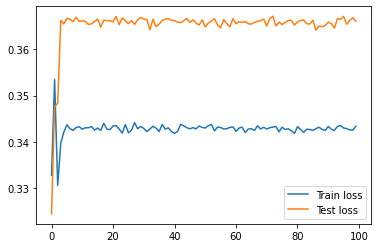

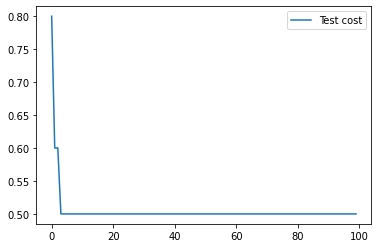

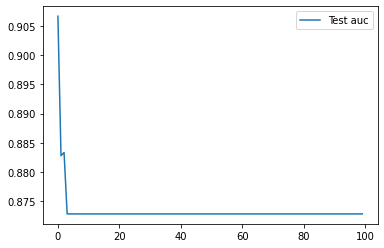

Prob. tc


 24%|██▍       | 24/100 [01:58<06:14,  4.92s/it]

Epoch    24: reducing learning rate of group 0 to 5.0000e-02.


 41%|████      | 41/100 [03:22<04:51,  4.94s/it]

Epoch    41: reducing learning rate of group 0 to 2.5000e-02.


 61%|██████    | 61/100 [05:00<03:11,  4.91s/it]

Epoch    61: reducing learning rate of group 0 to 1.2500e-02.


 74%|███████▍  | 74/100 [06:04<02:07,  4.92s/it]

Epoch    74: reducing learning rate of group 0 to 6.2500e-03.


 85%|████████▌ | 85/100 [06:58<01:14,  4.97s/it]

Epoch    85: reducing learning rate of group 0 to 3.1250e-03.


 96%|█████████▌| 96/100 [07:52<00:19,  4.95s/it]

Epoch    96: reducing learning rate of group 0 to 1.5625e-03.


100%|██████████| 100/100 [08:12<00:00,  4.93s/it]


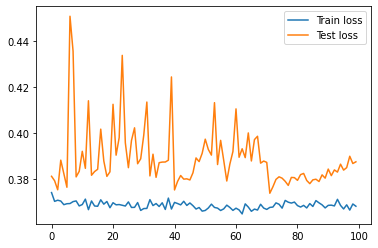

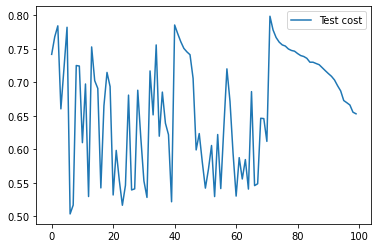

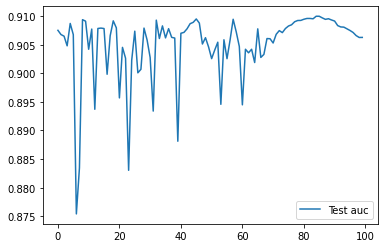

In [7]:
CUDA = True
C = 0.8
model_zoo = ['rnn_vitals_1hr','rnn_vitals_2hr','rnn_vitals_6hr','rnn_vitals_12hr',
             'rnn_vitals_labs_1hr','rnn_vitals_labs_2hr','rnn_vitals_labs_6hr','rnn_vitals_labs_12hr',
             'rnn_vitals_labs_csu_12hr']
model_costs = [0.5,0.6,0.8,1,0.5,0.6,0.8,1.1,1.2]

class_weights = torch.Tensor([1,20]).float()
if CUDA:
    class_weights = class_weights.cuda()
criterion = nn.NLLLoss(weight=class_weights)

epochs = 100
lr = 1e-1

new_results = {}

validation_results_dir = '../rnn/prediction_on_validation_results/'
test_results_dir = '../rnn/prediction_on_test_results/'

out_dir = 'saved_models/'
file_name = f'{len(model_zoo)}_models_C{C}_cw{class_weights[-1].item()}'

print('Entropy no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Entropy_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Entropy_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Entropy tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}EntropyTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Entropy_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Prob_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Prob_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}ProbTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Prob_TC']= (train_losses, test_losses, test_costs, test_aucs)

Entropy no tc


 19%|█▉        | 19/100 [01:34<06:40,  4.94s/it]

Epoch    19: reducing learning rate of group 0 to 5.0000e-02.


100%|██████████| 100/100 [08:09<00:00,  4.89s/it]


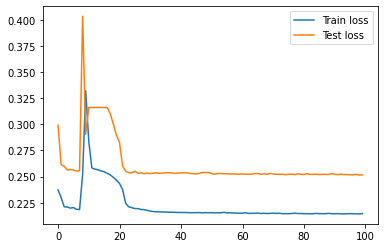

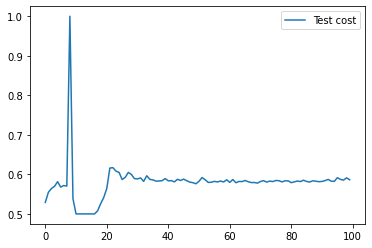

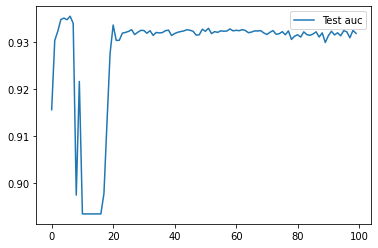

Entropy tc


 48%|████▊     | 48/100 [03:12<03:21,  3.88s/it]

Epoch    48: reducing learning rate of group 0 to 5.0000e-02.


 59%|█████▉    | 59/100 [04:02<03:18,  4.83s/it]

Epoch    59: reducing learning rate of group 0 to 2.5000e-02.


 79%|███████▉  | 79/100 [05:40<01:43,  4.91s/it]

Epoch    79: reducing learning rate of group 0 to 1.2500e-02.


100%|██████████| 100/100 [07:23<00:00,  4.44s/it]


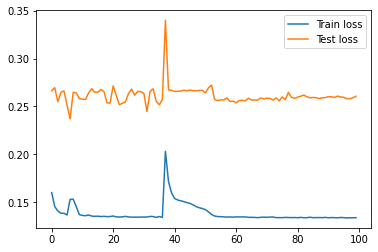

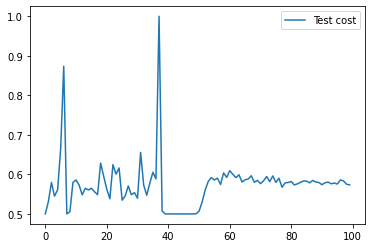

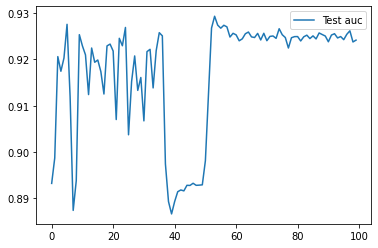

Prob. no tc


 15%|█▌        | 15/100 [01:14<06:56,  4.90s/it]

Epoch    15: reducing learning rate of group 0 to 5.0000e-02.


 26%|██▌       | 26/100 [02:08<06:02,  4.90s/it]

Epoch    26: reducing learning rate of group 0 to 2.5000e-02.


 37%|███▋      | 37/100 [03:02<05:10,  4.93s/it]

Epoch    37: reducing learning rate of group 0 to 1.2500e-02.


 48%|████▊     | 48/100 [03:56<04:15,  4.91s/it]

Epoch    48: reducing learning rate of group 0 to 6.2500e-03.


 59%|█████▉    | 59/100 [04:50<03:20,  4.89s/it]

Epoch    59: reducing learning rate of group 0 to 3.1250e-03.


 70%|███████   | 70/100 [05:44<02:26,  4.89s/it]

Epoch    70: reducing learning rate of group 0 to 1.5625e-03.


 81%|████████  | 81/100 [06:38<01:33,  4.94s/it]

Epoch    81: reducing learning rate of group 0 to 7.8125e-04.


 92%|█████████▏| 92/100 [07:32<00:39,  4.92s/it]

Epoch    92: reducing learning rate of group 0 to 3.9063e-04.


100%|██████████| 100/100 [08:12<00:00,  4.93s/it]


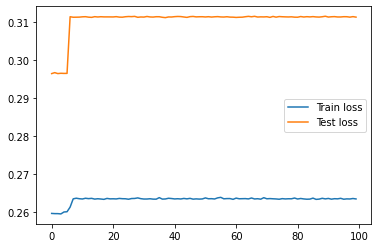

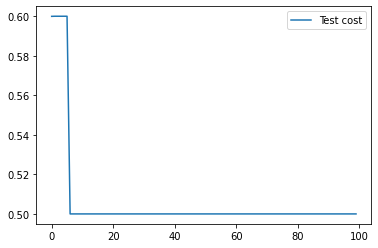

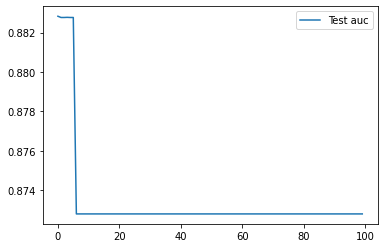

Prob. tc


 27%|██▋       | 27/100 [02:13<05:51,  4.81s/it]

Epoch    27: reducing learning rate of group 0 to 5.0000e-02.


 38%|███▊      | 38/100 [03:07<05:04,  4.92s/it]

Epoch    38: reducing learning rate of group 0 to 2.5000e-02.


 49%|████▉     | 49/100 [03:57<03:29,  4.11s/it]

Epoch    49: reducing learning rate of group 0 to 1.2500e-02.


 60%|██████    | 60/100 [04:40<02:36,  3.91s/it]

Epoch    60: reducing learning rate of group 0 to 6.2500e-03.


 71%|███████   | 71/100 [05:33<02:21,  4.89s/it]

Epoch    71: reducing learning rate of group 0 to 3.1250e-03.


 82%|████████▏ | 82/100 [06:27<01:29,  4.95s/it]

Epoch    82: reducing learning rate of group 0 to 1.5625e-03.


 93%|█████████▎| 93/100 [07:22<00:34,  4.95s/it]

Epoch    93: reducing learning rate of group 0 to 7.8125e-04.


100%|██████████| 100/100 [07:56<00:00,  4.77s/it]


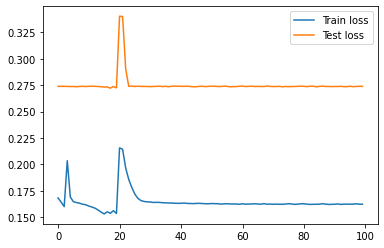

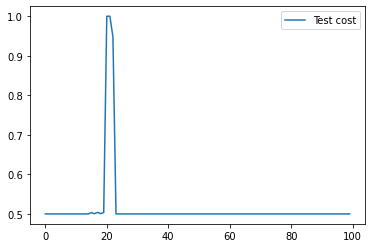

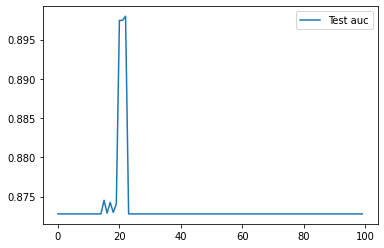

In [8]:
CUDA = True
C = 1.1
model_zoo = ['rnn_vitals_1hr','rnn_vitals_2hr','rnn_vitals_6hr','rnn_vitals_12hr',
             'rnn_vitals_labs_1hr','rnn_vitals_labs_2hr','rnn_vitals_labs_6hr','rnn_vitals_labs_12hr',
             'rnn_vitals_labs_csu_12hr']
model_costs = [0.5,0.6,0.8,1,0.5,0.6,0.8,1.1,1.2]

class_weights = torch.Tensor([1,5]).float()
if CUDA:
    class_weights = class_weights.cuda()
criterion = nn.NLLLoss(weight=class_weights)

epochs = 100
lr = 1e-1

new_results = {}

validation_results_dir = '../rnn/prediction_on_validation_results/'
test_results_dir = '../rnn/prediction_on_test_results/'

out_dir = 'saved_models/'
file_name = f'{len(model_zoo)}_models_C{C}_cw{class_weights[-1].item()}'

print('Entropy no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Entropy_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Entropy_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Entropy tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}EntropyTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Entropy_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Prob_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Prob_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}ProbTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Prob_TC']= (train_losses, test_losses, test_costs, test_aucs)

Entropy no tc


 59%|█████▉    | 59/100 [04:52<03:22,  4.93s/it]

Epoch    59: reducing learning rate of group 0 to 5.0000e-02.


 71%|███████   | 71/100 [05:51<02:22,  4.92s/it]

Epoch    71: reducing learning rate of group 0 to 2.5000e-02.


 89%|████████▉ | 89/100 [07:19<00:54,  4.92s/it]

Epoch    89: reducing learning rate of group 0 to 1.2500e-02.


100%|██████████| 100/100 [08:14<00:00,  4.94s/it]


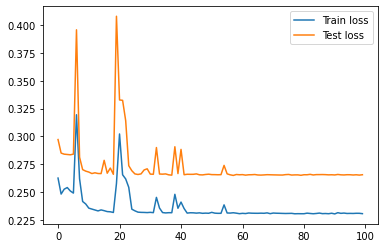

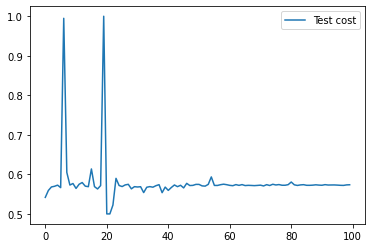

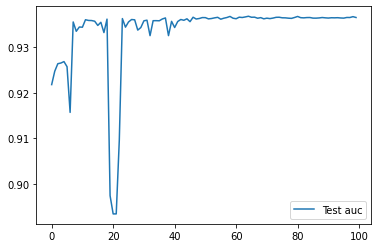

Entropy tc


 30%|███       | 30/100 [02:24<05:20,  4.58s/it]

Epoch    30: reducing learning rate of group 0 to 5.0000e-02.


 52%|█████▏    | 52/100 [04:12<03:57,  4.94s/it]

Epoch    52: reducing learning rate of group 0 to 2.5000e-02.


 71%|███████   | 71/100 [05:46<02:22,  4.91s/it]

Epoch    71: reducing learning rate of group 0 to 1.2500e-02.


 88%|████████▊ | 88/100 [07:09<00:59,  4.95s/it]

Epoch    88: reducing learning rate of group 0 to 6.2500e-03.


 99%|█████████▉| 99/100 [08:04<00:04,  4.97s/it]

Epoch    99: reducing learning rate of group 0 to 3.1250e-03.


100%|██████████| 100/100 [08:09<00:00,  4.90s/it]


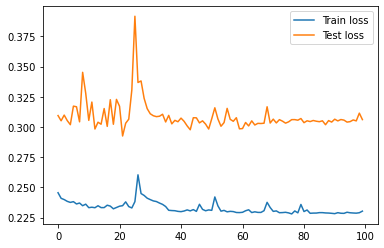

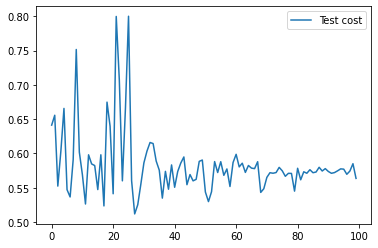

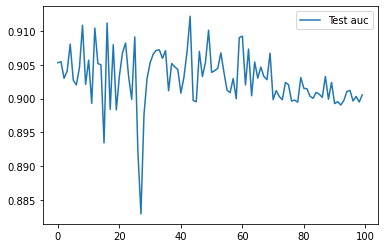

Prob. no tc


 19%|█▉        | 19/100 [01:34<06:42,  4.96s/it]

Epoch    19: reducing learning rate of group 0 to 5.0000e-02.


 32%|███▏      | 32/100 [02:37<05:31,  4.88s/it]

Epoch    32: reducing learning rate of group 0 to 2.5000e-02.


 43%|████▎     | 43/100 [03:32<04:40,  4.93s/it]

Epoch    43: reducing learning rate of group 0 to 1.2500e-02.


 54%|█████▍    | 54/100 [04:26<03:47,  4.95s/it]

Epoch    54: reducing learning rate of group 0 to 6.2500e-03.


100%|██████████| 100/100 [08:13<00:00,  4.93s/it]


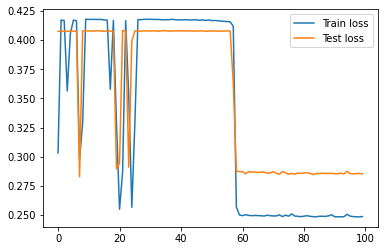

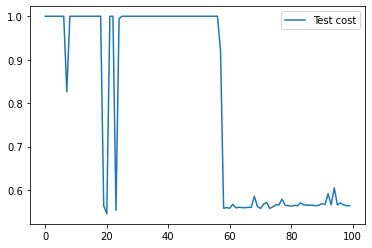

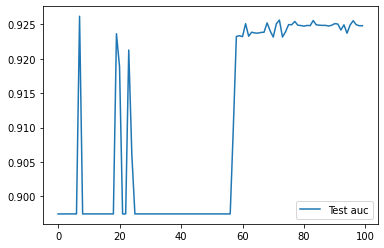

Prob. tc


 20%|██        | 20/100 [01:39<06:37,  4.97s/it]

Epoch    20: reducing learning rate of group 0 to 5.0000e-02.


 31%|███       | 31/100 [02:33<05:40,  4.94s/it]

Epoch    31: reducing learning rate of group 0 to 2.5000e-02.


 42%|████▏     | 42/100 [03:28<04:47,  4.97s/it]

Epoch    42: reducing learning rate of group 0 to 1.2500e-02.


 53%|█████▎    | 53/100 [04:23<03:53,  4.97s/it]

Epoch    53: reducing learning rate of group 0 to 6.2500e-03.


 64%|██████▍   | 64/100 [05:17<02:58,  4.96s/it]

Epoch    64: reducing learning rate of group 0 to 3.1250e-03.


 75%|███████▌  | 75/100 [06:12<02:03,  4.95s/it]

Epoch    75: reducing learning rate of group 0 to 1.5625e-03.


 86%|████████▌ | 86/100 [07:06<01:08,  4.91s/it]

Epoch    86: reducing learning rate of group 0 to 7.8125e-04.


 97%|█████████▋| 97/100 [08:00<00:14,  4.96s/it]

Epoch    97: reducing learning rate of group 0 to 3.9063e-04.


100%|██████████| 100/100 [08:15<00:00,  4.95s/it]


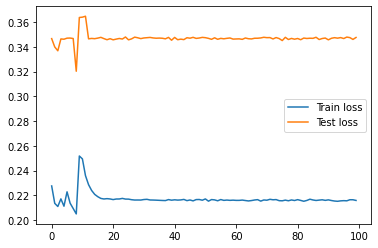

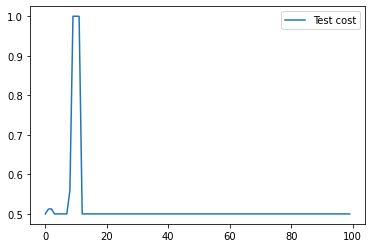

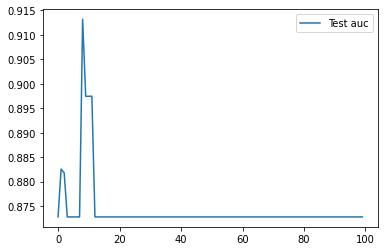

In [9]:
CUDA = True
C = 1.1
model_zoo = ['rnn_vitals_1hr','rnn_vitals_2hr','rnn_vitals_6hr','rnn_vitals_12hr',
             'rnn_vitals_labs_1hr','rnn_vitals_labs_2hr','rnn_vitals_labs_6hr','rnn_vitals_labs_12hr',
             'rnn_vitals_labs_csu_12hr']
model_costs = [0.5,0.6,0.8,1,0.5,0.6,0.8,1.1,1.2]

class_weights = torch.Tensor([1,10]).float()
if CUDA:
    class_weights = class_weights.cuda()
criterion = nn.NLLLoss(weight=class_weights)

epochs = 100
lr = 1e-1

new_results = {}

validation_results_dir = '../rnn/prediction_on_validation_results/'
test_results_dir = '../rnn/prediction_on_test_results/'

out_dir = 'saved_models/'
file_name = f'{len(model_zoo)}_models_C{C}_cw{class_weights[-1].item()}'

print('Entropy no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Entropy_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Entropy_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Entropy tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}EntropyTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Entropy_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Prob_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Prob_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}ProbTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Prob_TC']= (train_losses, test_losses, test_costs, test_aucs)

Entropy no tc


 39%|███▉      | 39/100 [03:13<05:00,  4.93s/it]

Epoch    39: reducing learning rate of group 0 to 5.0000e-02.


 60%|██████    | 60/100 [04:49<03:16,  4.91s/it]

Epoch    60: reducing learning rate of group 0 to 2.5000e-02.


 90%|█████████ | 90/100 [07:18<00:49,  4.94s/it]

Epoch    90: reducing learning rate of group 0 to 1.2500e-02.


100%|██████████| 100/100 [08:08<00:00,  4.88s/it]


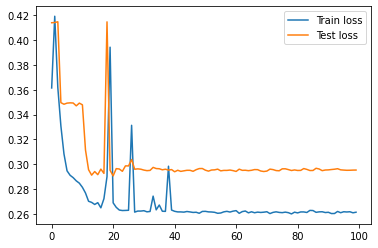

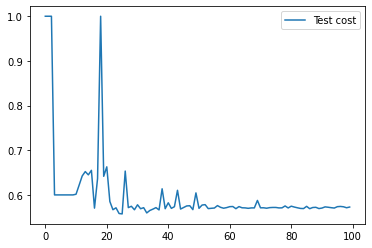

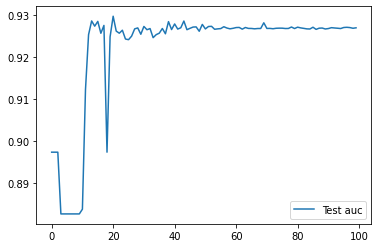

Entropy tc


 34%|███▍      | 34/100 [02:47<05:24,  4.92s/it]

Epoch    34: reducing learning rate of group 0 to 5.0000e-02.


 45%|████▌     | 45/100 [03:42<04:31,  4.94s/it]

Epoch    45: reducing learning rate of group 0 to 2.5000e-02.


 56%|█████▌    | 56/100 [04:36<03:37,  4.93s/it]

Epoch    56: reducing learning rate of group 0 to 1.2500e-02.


 67%|██████▋   | 67/100 [05:31<02:48,  5.10s/it]

Epoch    67: reducing learning rate of group 0 to 6.2500e-03.


 78%|███████▊  | 78/100 [06:26<01:51,  5.06s/it]

Epoch    78: reducing learning rate of group 0 to 3.1250e-03.


 89%|████████▉ | 89/100 [07:23<00:55,  5.06s/it]

Epoch    89: reducing learning rate of group 0 to 1.5625e-03.


100%|██████████| 100/100 [08:17<00:00,  4.98s/it]

Epoch   100: reducing learning rate of group 0 to 7.8125e-04.


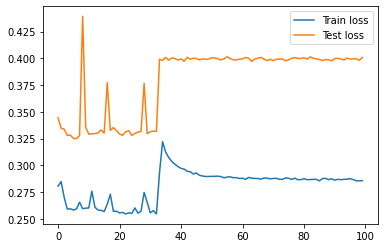

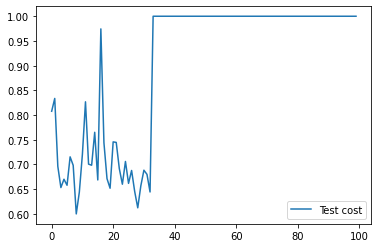

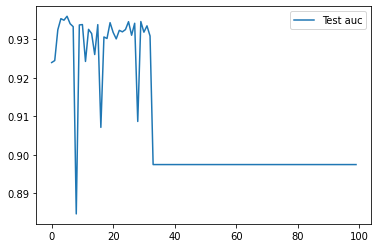

Prob. no tc


 17%|█▋        | 17/100 [01:27<07:03,  5.11s/it]

Epoch    17: reducing learning rate of group 0 to 5.0000e-02.


 28%|██▊       | 28/100 [02:25<06:21,  5.30s/it]

Epoch    28: reducing learning rate of group 0 to 2.5000e-02.


 39%|███▉      | 39/100 [03:18<04:48,  4.73s/it]

Epoch    39: reducing learning rate of group 0 to 1.2500e-02.


 50%|█████     | 50/100 [04:13<04:05,  4.91s/it]

Epoch    50: reducing learning rate of group 0 to 6.2500e-03.


 61%|██████    | 61/100 [05:09<03:21,  5.18s/it]

Epoch    61: reducing learning rate of group 0 to 3.1250e-03.


 72%|███████▏  | 72/100 [06:07<02:25,  5.18s/it]

Epoch    72: reducing learning rate of group 0 to 1.5625e-03.


 83%|████████▎ | 83/100 [06:56<01:11,  4.23s/it]

Epoch    83: reducing learning rate of group 0 to 7.8125e-04.


 94%|█████████▍| 94/100 [07:49<00:30,  5.16s/it]

Epoch    94: reducing learning rate of group 0 to 3.9063e-04.


100%|██████████| 100/100 [08:16<00:00,  4.96s/it]


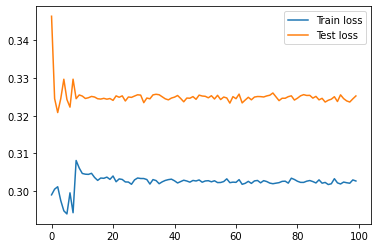

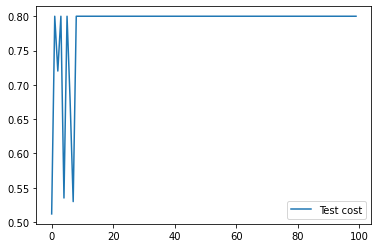

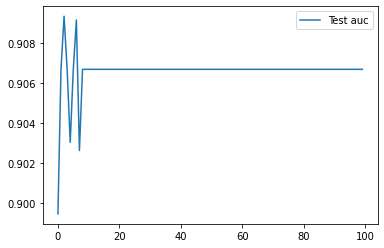

Prob. tc


 25%|██▌       | 25/100 [02:01<06:39,  5.33s/it]

Epoch    25: reducing learning rate of group 0 to 5.0000e-02.


 70%|███████   | 70/100 [05:47<02:29,  4.99s/it]

Epoch    70: reducing learning rate of group 0 to 2.5000e-02.


 81%|████████  | 81/100 [06:42<01:35,  5.01s/it]

Epoch    81: reducing learning rate of group 0 to 1.2500e-02.


 97%|█████████▋| 97/100 [08:08<00:15,  5.26s/it]

Epoch    97: reducing learning rate of group 0 to 6.2500e-03.


100%|██████████| 100/100 [08:23<00:00,  5.04s/it]


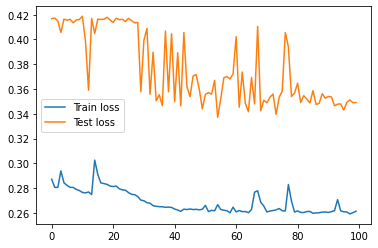

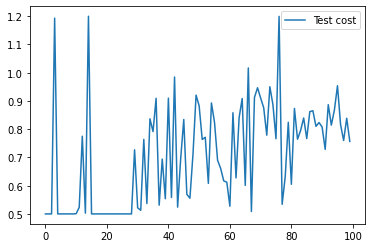

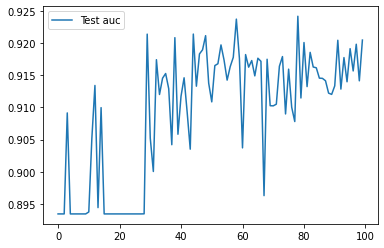

In [10]:
CUDA = True
C = 1.1
model_zoo = ['rnn_vitals_1hr','rnn_vitals_2hr','rnn_vitals_6hr','rnn_vitals_12hr',
             'rnn_vitals_labs_1hr','rnn_vitals_labs_2hr','rnn_vitals_labs_6hr','rnn_vitals_labs_12hr',
             'rnn_vitals_labs_csu_12hr']
model_costs = [0.5,0.6,0.8,1,0.5,0.6,0.8,1.1,1.2]

class_weights = torch.Tensor([1,20]).float()
if CUDA:
    class_weights = class_weights.cuda()
criterion = nn.NLLLoss(weight=class_weights)

epochs = 100
lr = 1e-1

new_results = {}

validation_results_dir = '../rnn/prediction_on_validation_results/'
test_results_dir = '../rnn/prediction_on_test_results/'

out_dir = 'saved_models/'
file_name = f'{len(model_zoo)}_models_C{C}_cw{class_weights[-1].item()}'

print('Entropy no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Entropy_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Entropy_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Entropy tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}EntropyTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Entropy_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Prob_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Prob_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}ProbTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, epochs=epochs, CUDA=CUDA)
new_results['Prob_TC']= (train_losses, test_losses, test_costs, test_aucs)

Entropy no tc


 34%|███▍      | 34/100 [02:46<05:23,  4.90s/it]

Epoch    34: reducing learning rate of group 0 to 5.0000e-02.


 55%|█████▌    | 55/100 [04:32<03:42,  4.95s/it]

Epoch    55: reducing learning rate of group 0 to 2.5000e-02.


 73%|███████▎  | 73/100 [06:00<02:12,  4.89s/it]

Epoch    73: reducing learning rate of group 0 to 1.2500e-02.


 84%|████████▍ | 84/100 [06:54<01:18,  4.90s/it]

Epoch    84: reducing learning rate of group 0 to 6.2500e-03.


100%|██████████| 100/100 [08:16<00:00,  4.96s/it]


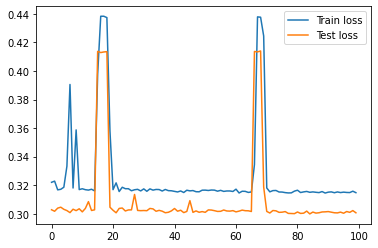

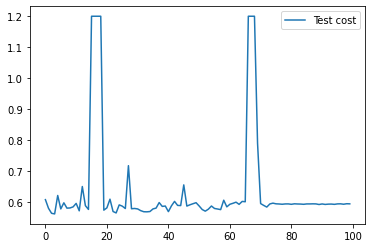

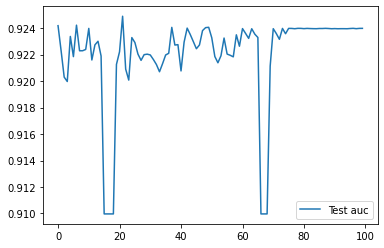

Entropy tc


 55%|█████▌    | 55/100 [04:44<03:43,  4.97s/it]

Epoch    55: reducing learning rate of group 0 to 5.0000e-02.


 99%|█████████▉| 99/100 [08:30<00:04,  4.93s/it]

Epoch    99: reducing learning rate of group 0 to 2.5000e-02.


100%|██████████| 100/100 [08:35<00:00,  5.15s/it]


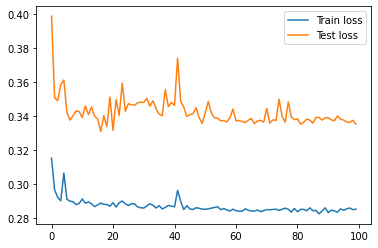

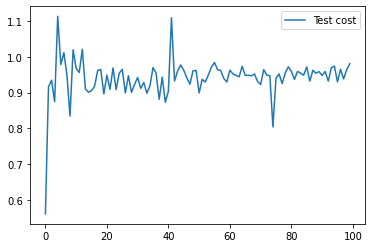

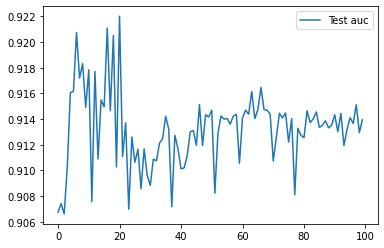

Prob. no tc


 40%|████      | 40/100 [03:25<04:55,  4.93s/it]

Epoch    40: reducing learning rate of group 0 to 5.0000e-02.


 76%|███████▌  | 76/100 [06:30<02:24,  6.01s/it]

Epoch    76: reducing learning rate of group 0 to 2.5000e-02.


 92%|█████████▏| 92/100 [07:55<00:39,  4.95s/it]

Epoch    92: reducing learning rate of group 0 to 1.2500e-02.


100%|██████████| 100/100 [08:33<00:00,  5.13s/it]


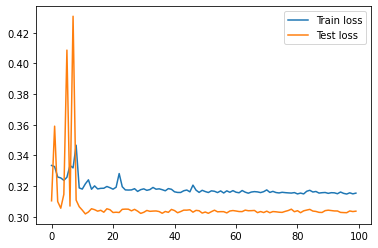

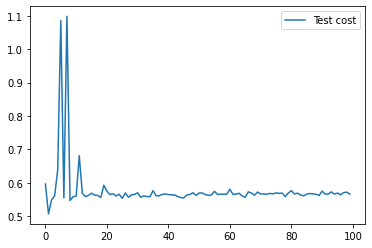

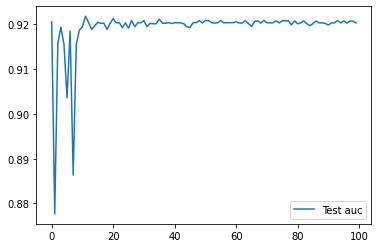

Prob. tc


 22%|██▏       | 22/100 [01:44<06:39,  5.12s/it]

Epoch    22: reducing learning rate of group 0 to 5.0000e-02.


 33%|███▎      | 33/100 [02:39<05:30,  4.94s/it]

Epoch    33: reducing learning rate of group 0 to 2.5000e-02.


 44%|████▍     | 44/100 [03:33<04:35,  4.92s/it]

Epoch    44: reducing learning rate of group 0 to 1.2500e-02.


 55%|█████▌    | 55/100 [04:26<03:40,  4.90s/it]

Epoch    55: reducing learning rate of group 0 to 6.2500e-03.


 66%|██████▌   | 66/100 [05:21<02:47,  4.92s/it]

Epoch    66: reducing learning rate of group 0 to 3.1250e-03.


 77%|███████▋  | 77/100 [06:15<01:53,  4.92s/it]

Epoch    77: reducing learning rate of group 0 to 1.5625e-03.


 88%|████████▊ | 88/100 [07:09<00:59,  5.00s/it]

Epoch    88: reducing learning rate of group 0 to 7.8125e-04.


 99%|█████████▉| 99/100 [08:06<00:05,  5.07s/it]

Epoch    99: reducing learning rate of group 0 to 3.9063e-04.


100%|██████████| 100/100 [08:11<00:00,  4.92s/it]


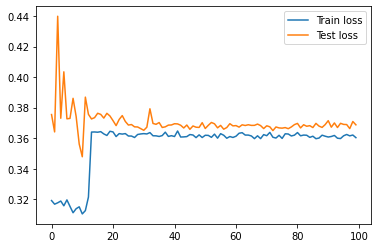

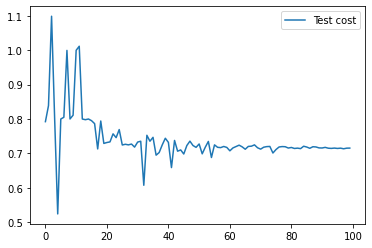

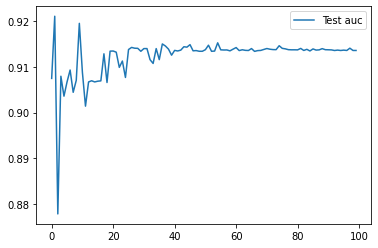

In [13]:
CUDA = True
C = 1.1
model_zoo = ['rnn_vitals_1hr','rnn_vitals_2hr','rnn_vitals_6hr','rnn_vitals_12hr',
             'rnn_vitals_labs_1hr','rnn_vitals_labs_2hr','rnn_vitals_labs_6hr','rnn_vitals_labs_12hr',
             'rnn_vitals_labs_csu_12hr']
model_costs = [0.5,0.6,0.8,1,0.5,0.6,0.8,1.1,1.2]

class_weights = torch.Tensor([1,20]).float()
if CUDA:
    class_weights = class_weights.cuda()
criterion = nn.NLLLoss(weight=class_weights)

epochs = 100
lr = 1e-1
lambda1 = 1e-2
lambda2 = 1e-2
    
new_results = {}

validation_results_dir = '../rnn/prediction_on_validation_results/'
test_results_dir = '../rnn/prediction_on_test_results/'

out_dir = 'saved_models/'
file_name = f'{len(model_zoo)}_models_C{C}_cw{class_weights[-1].item()}_lambda2{lambda2}'

print('Entropy no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Entropy_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, lambda1=lambda1, lambda2=lambda2, epochs=epochs, CUDA=CUDA)
new_results['Entropy_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Entropy tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}EntropyTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, lambda1=lambda1, lambda2=lambda2, epochs=epochs, CUDA=CUDA)
new_results['Entropy_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Prob_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, lambda1=lambda1, lambda2=lambda2, epochs=epochs, CUDA=CUDA)
new_results['Prob_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}ProbTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, lambda1=lambda1, lambda2=lambda2, epochs=epochs, CUDA=CUDA)
new_results['Prob_TC']= (train_losses, test_losses, test_costs, test_aucs)

Entropy no tc


 61%|██████    | 61/100 [05:00<03:03,  4.70s/it]

Epoch    61: reducing learning rate of group 0 to 5.0000e-02.


 80%|████████  | 80/100 [06:35<01:40,  5.03s/it]

Epoch    80: reducing learning rate of group 0 to 2.5000e-02.


 99%|█████████▉| 99/100 [08:15<00:05,  5.21s/it]

Epoch    99: reducing learning rate of group 0 to 1.2500e-02.


100%|██████████| 100/100 [08:20<00:00,  5.00s/it]


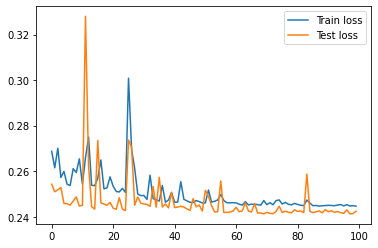

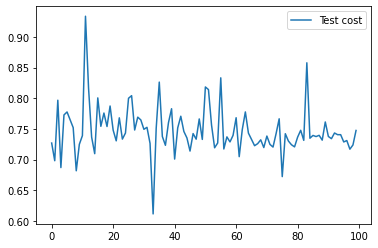

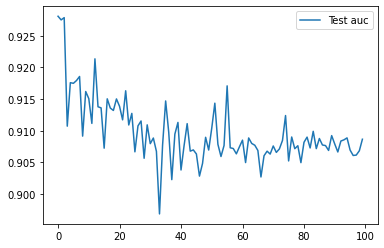

Entropy tc


 54%|█████▍    | 54/100 [04:23<03:48,  4.98s/it]

Epoch    54: reducing learning rate of group 0 to 5.0000e-02.


 73%|███████▎  | 73/100 [05:58<02:13,  4.95s/it]

Epoch    73: reducing learning rate of group 0 to 2.5000e-02.


 91%|█████████ | 91/100 [07:26<00:44,  4.91s/it]

Epoch    91: reducing learning rate of group 0 to 1.2500e-02.


100%|██████████| 100/100 [08:09<00:00,  4.89s/it]


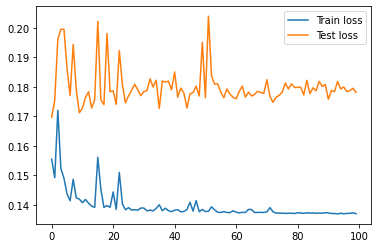

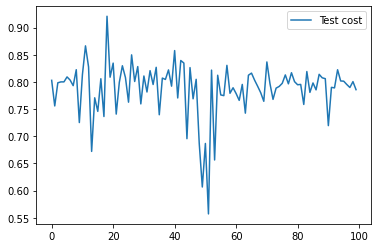

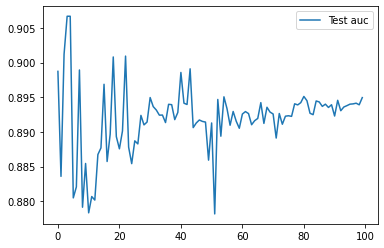

Prob. no tc


100%|██████████| 100/100 [07:54<00:00,  4.75s/it]


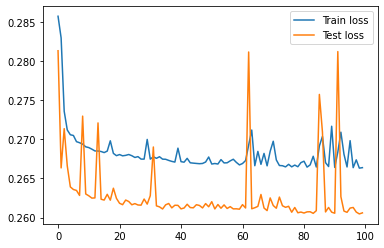

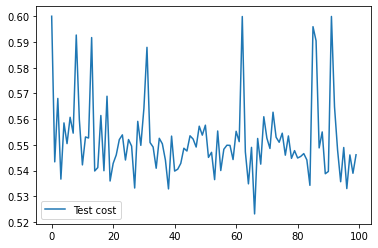

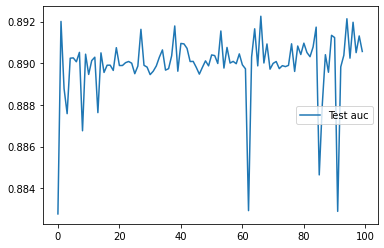

Prob. tc


 12%|█▏        | 12/100 [01:00<07:23,  5.04s/it]

Epoch    12: reducing learning rate of group 0 to 5.0000e-02.


 23%|██▎       | 23/100 [01:58<06:39,  5.19s/it]

Epoch    23: reducing learning rate of group 0 to 2.5000e-02.


 34%|███▍      | 34/100 [02:49<04:42,  4.28s/it]

Epoch    34: reducing learning rate of group 0 to 1.2500e-02.


 45%|████▌     | 45/100 [03:38<04:24,  4.80s/it]

Epoch    45: reducing learning rate of group 0 to 6.2500e-03.


 56%|█████▌    | 56/100 [04:34<03:44,  5.10s/it]

Epoch    56: reducing learning rate of group 0 to 3.1250e-03.


 67%|██████▋   | 67/100 [05:24<02:33,  4.64s/it]

Epoch    67: reducing learning rate of group 0 to 1.5625e-03.


 78%|███████▊  | 78/100 [06:22<01:54,  5.21s/it]

Epoch    78: reducing learning rate of group 0 to 7.8125e-04.


 89%|████████▉ | 89/100 [07:18<00:55,  5.02s/it]

Epoch    89: reducing learning rate of group 0 to 3.9063e-04.


100%|██████████| 100/100 [08:17<00:00,  4.98s/it]

Epoch   100: reducing learning rate of group 0 to 1.9531e-04.


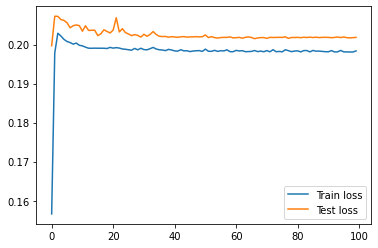

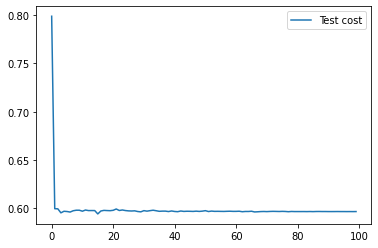

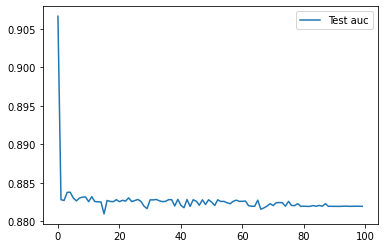

In [14]:
CUDA = True
C = 2.0
model_zoo = ['rnn_vitals_1hr','rnn_vitals_2hr','rnn_vitals_6hr','rnn_vitals_12hr',
             'rnn_vitals_labs_1hr','rnn_vitals_labs_2hr','rnn_vitals_labs_6hr','rnn_vitals_labs_12hr',
             'rnn_vitals_labs_csu_12hr']
model_costs = [0.5,0.6,0.8,1,0.5,0.6,0.8,1.1,1.2]

class_weights = torch.Tensor([1,2]).float()
if CUDA:
    class_weights = class_weights.cuda()
criterion = nn.NLLLoss(weight=class_weights)

epochs = 100
lr = 1e-1
lambda1 = 1e-3
lambda2 = 1e-3
    
new_results = {}

validation_results_dir = '../rnn/prediction_on_validation_results/'
test_results_dir = '../rnn/prediction_on_test_results/'

out_dir = 'saved_models/'
file_name = f'{len(model_zoo)}_models_C{C}_cw{class_weights[-1].item()}_lambda1{lambda1}_lambda2{lambda2}'

print('Entropy no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Entropy_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, lambda1=lambda1, lambda2=lambda2, epochs=epochs, CUDA=CUDA)
new_results['Entropy_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Entropy tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}EntropyTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, lambda1=lambda1, lambda2=lambda2, epochs=epochs, CUDA=CUDA)
new_results['Entropy_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Prob_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, lambda1=lambda1, lambda2=lambda2, epochs=epochs, CUDA=CUDA)
new_results['Prob_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}ProbTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, lambda1=lambda1, lambda2=lambda2, epochs=epochs, CUDA=CUDA)
new_results['Prob_TC']= (train_losses, test_losses, test_costs, test_aucs)

Entropy no tc


 17%|█▋        | 17/100 [01:29<07:17,  5.27s/it]

Epoch    17: reducing learning rate of group 0 to 5.0000e-02.


 28%|██▊       | 28/100 [02:22<05:37,  4.69s/it]

Epoch    28: reducing learning rate of group 0 to 2.5000e-02.


 39%|███▉      | 39/100 [03:15<05:02,  4.96s/it]

Epoch    39: reducing learning rate of group 0 to 1.2500e-02.


 50%|█████     | 50/100 [04:10<04:11,  5.02s/it]

Epoch    50: reducing learning rate of group 0 to 6.2500e-03.


 61%|██████    | 61/100 [05:08<03:19,  5.11s/it]

Epoch    61: reducing learning rate of group 0 to 3.1250e-03.


 72%|███████▏  | 72/100 [06:02<02:21,  5.05s/it]

Epoch    72: reducing learning rate of group 0 to 1.5625e-03.


 83%|████████▎ | 83/100 [06:55<01:15,  4.46s/it]

Epoch    83: reducing learning rate of group 0 to 7.8125e-04.


 94%|█████████▍| 94/100 [07:48<00:30,  5.05s/it]

Epoch    94: reducing learning rate of group 0 to 3.9063e-04.


100%|██████████| 100/100 [08:19<00:00,  4.99s/it]


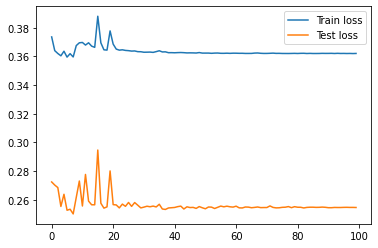

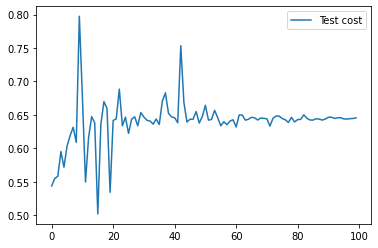

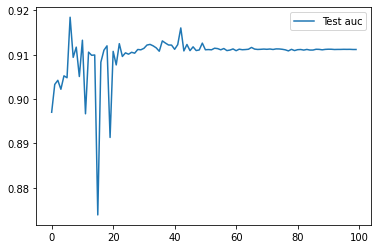

Entropy tc


 57%|█████▋    | 57/100 [04:27<03:32,  4.94s/it]

Epoch    57: reducing learning rate of group 0 to 5.0000e-02.


 91%|█████████ | 91/100 [07:14<00:45,  5.07s/it]

Epoch    91: reducing learning rate of group 0 to 2.5000e-02.


100%|██████████| 100/100 [08:04<00:00,  4.85s/it]


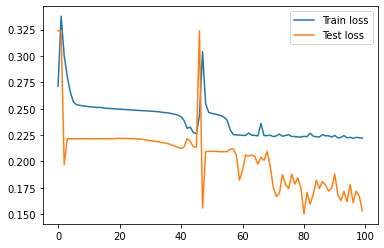

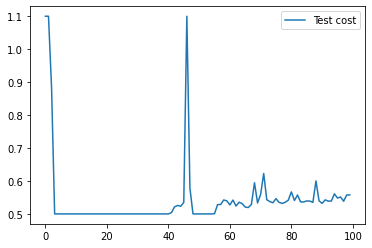

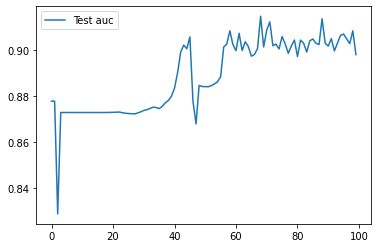

Prob. no tc


 12%|█▏        | 12/100 [01:00<07:25,  5.06s/it]

Epoch    12: reducing learning rate of group 0 to 5.0000e-02.


 23%|██▎       | 23/100 [01:56<06:31,  5.08s/it]

Epoch    23: reducing learning rate of group 0 to 2.5000e-02.


 34%|███▍      | 34/100 [02:53<05:31,  5.02s/it]

Epoch    34: reducing learning rate of group 0 to 1.2500e-02.


 45%|████▌     | 45/100 [03:53<05:31,  6.02s/it]

Epoch    45: reducing learning rate of group 0 to 6.2500e-03.


 56%|█████▌    | 56/100 [04:51<03:42,  5.06s/it]

Epoch    56: reducing learning rate of group 0 to 3.1250e-03.


 67%|██████▋   | 67/100 [05:47<02:48,  5.11s/it]

Epoch    67: reducing learning rate of group 0 to 1.5625e-03.


 78%|███████▊  | 78/100 [06:43<01:50,  5.04s/it]

Epoch    78: reducing learning rate of group 0 to 7.8125e-04.


 89%|████████▉ | 89/100 [07:38<00:53,  4.91s/it]

Epoch    89: reducing learning rate of group 0 to 3.9063e-04.


100%|██████████| 100/100 [08:33<00:00,  5.13s/it]

Epoch   100: reducing learning rate of group 0 to 1.9531e-04.


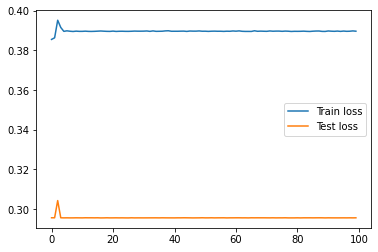

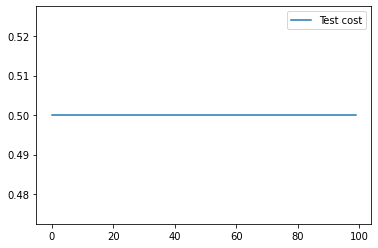

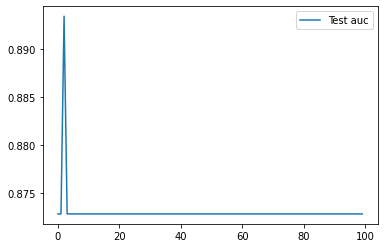

Prob. tc


 23%|██▎       | 23/100 [01:58<06:33,  5.11s/it]

Epoch    23: reducing learning rate of group 0 to 5.0000e-02.


 34%|███▍      | 34/100 [02:54<05:32,  5.04s/it]

Epoch    34: reducing learning rate of group 0 to 2.5000e-02.


 45%|████▌     | 45/100 [03:48<04:36,  5.03s/it]

Epoch    45: reducing learning rate of group 0 to 1.2500e-02.


 56%|█████▌    | 56/100 [04:43<03:36,  4.93s/it]

Epoch    56: reducing learning rate of group 0 to 6.2500e-03.


 67%|██████▋   | 67/100 [05:39<02:47,  5.09s/it]

Epoch    67: reducing learning rate of group 0 to 3.1250e-03.


 78%|███████▊  | 78/100 [06:35<01:52,  5.10s/it]

Epoch    78: reducing learning rate of group 0 to 1.5625e-03.


 89%|████████▉ | 89/100 [07:31<00:56,  5.15s/it]

Epoch    89: reducing learning rate of group 0 to 7.8125e-04.


100%|██████████| 100/100 [08:26<00:00,  5.07s/it]

Epoch   100: reducing learning rate of group 0 to 3.9063e-04.


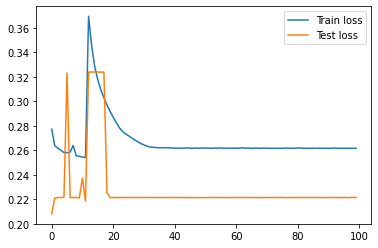

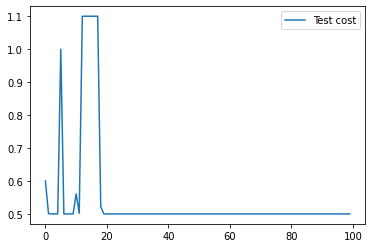

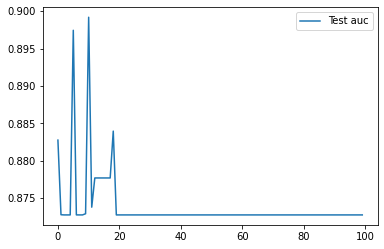

In [15]:
CUDA = True
C = 0.6
model_zoo = ['rnn_vitals_1hr','rnn_vitals_2hr','rnn_vitals_6hr','rnn_vitals_12hr',
             'rnn_vitals_labs_1hr','rnn_vitals_labs_2hr','rnn_vitals_labs_6hr','rnn_vitals_labs_12hr',
             'rnn_vitals_labs_csu_12hr']
model_costs = [0.5,0.6,0.8,1,0.5,0.6,0.8,1.1,1.2]

class_weights = torch.Tensor([1,2]).float()
if CUDA:
    class_weights = class_weights.cuda()
criterion = nn.NLLLoss(weight=class_weights)

epochs = 100
lr = 1e-1
lambda1 = 1e-1
lambda2 = 1e-1
    
new_results = {}

validation_results_dir = '../rnn/prediction_on_validation_results/'
test_results_dir = '../rnn/prediction_on_test_results/'

out_dir = 'saved_models/'
file_name = f'{len(model_zoo)}_models_C{C}_cw{class_weights[-1].item()}_lambda1{lambda1}_lambda2{lambda2}'

print('Entropy no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Entropy_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, lambda1=lambda1, lambda2=lambda2, epochs=epochs, CUDA=CUDA)
new_results['Entropy_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Entropy tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, confidence='entropy', tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,confidence='entropy',  tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}EntropyTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, lambda1=lambda1, lambda2=lambda2, epochs=epochs, CUDA=CUDA)
new_results['Entropy_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. no tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=False)
test_loader = load_data(test_results_dir, model_zoo, model_costs,  tc=False)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}Prob_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, lambda1=lambda1, lambda2=lambda2, epochs=epochs, CUDA=CUDA)
new_results['Prob_no_TC'] = (train_losses, test_losses, test_costs, test_aucs)

print('Prob. tc')
validation_loader = load_data(validation_results_dir, model_zoo, model_costs, tc=True)
test_loader = load_data(test_results_dir, model_zoo, model_costs,tc=True)

model = SoftGateCascade(len(model_zoo))
save_model_file = f'{out_dir}ProbTC_{file_name}'
model, train_losses, test_losses, test_costs, test_aucs = train_model(model, validation_loader, test_loader, C, save_model_file=save_model_file, lr=lr, lambda1=lambda1, lambda2=lambda2, epochs=epochs, CUDA=CUDA)
new_results['Prob_TC']= (train_losses, test_losses, test_costs, test_aucs)